We are an agency helping our customers purchase XoX (a made-up product) from various makers. Price is one of the most important things we care about. We need to estimate the price of a XoX before we recommend it to our customers. However, the estimations vary significantly with our employees' experience.

We would like you to build a machine learning model to accurately predict the price for a future purchase and provide insights to help us explain the predicted price to our customers. Please note that neither our customers nor us have any knowledge about machine learning. A sample of our sales record is available in ../data/sales.csv.

Preprocess, clean, analyze and visualized the provided data. A few sentences or plots describing your approach will suffice. Any thing you would like us to know about the price?
Build a machine learning model to help us determine the price for a purchase. Discuss why you choose the approaches, what alternatives you consider, and any concerns you have. How is the performance of your model?
Help us understand how the price is predicted (again, a few sentences will suffice).

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('./sales.csv')

# 1. Data Overview

In [2]:
df.dropna(subset=['price'], inplace=True)
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3186 entries, 0 to 3196
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cost           2211 non-null   object
 1   price          3186 non-null   object
 2   weight         3183 non-null   object
 3   purchase_date  3186 non-null   object
 4   product_type   3186 non-null   object
 5   product_level  3186 non-null   object
 6   maker          2365 non-null   object
 7   ingredient     2932 non-null   object
 8   height         3186 non-null   object
 9   width          3183 non-null   object
 10  depth          3183 non-null   object
dtypes: object(11)
memory usage: 298.7+ KB


In [4]:
print("Mssing value of maker: ", df.maker.isnull().sum())
print("Qty of Known makers: ", df.maker.nunique())
df.maker.value_counts()

Mssing value of maker:  821
Qty of Known makers:  879


M14196           17
M14346           16
M14170           15
M14163           15
M14164           13
                 ..
M14392            1
M14213            1
M14725            1
M14394            1
M14883,M15011     1
Name: maker, Length: 879, dtype: int64

With a total of 3186 rows of data, maker has 2365 value not null, with 879 unique values, and 821 missing values and none is dominant.  I would consider maker not a good variable to predict price. 

In [5]:
df['year'] = pd.to_datetime(df.purchase_date).dt.year
tmp = pd.DataFrame()
tmp['price'] = df['price'].map(lambda x: x if type(x) is float else float(x.strip('$').replace(',', '')))
tmp['cost'] = df['cost'].map(lambda x: x if type(x) is float else 1000*float(x.strip('$').strip('k')))
tmp['weight'] = df['weight'].map(lambda x: x if type(x) is float else float(x.split(' Ton')[0]) * 1000)
tmp['height'] = df['height'].map(lambda x: x if type(x) is float else float(x.strip('meters').strip()) * 100)
tmp['width'] = df['width'].map(lambda x: x if type(x) is float else float(x.strip(' cm')))
tmp['depth'] = df['depth'].map(lambda x: x if type(x) is float else float(x.strip(' cm')))
tmp['year'] = df['year']

tmp
tmp.cost.median(skipna=True)
tmp.cost.mean(skipna=True)

169019.44821347806

In [6]:
correlation_matrix = tmp.corr()
print(correlation_matrix)

           price      cost    weight    height     width     depth      year
price   1.000000  0.627414  0.146433  0.076193  0.081460  0.084387  0.126201
cost    0.627414  1.000000  0.201146  0.074708  0.121367  0.119569  0.107065
weight  0.146433  0.201146  1.000000  0.128382  0.254737  0.246442  0.058428
height  0.076193  0.074708  0.128382  1.000000 -0.851370 -0.837142 -0.026806
width   0.081460  0.121367  0.254737 -0.851370  1.000000  0.979355  0.043274
depth   0.084387  0.119569  0.246442 -0.837142  0.979355  1.000000  0.040989
year    0.126201  0.107065  0.058428 -0.026806  0.043274  0.040989  1.000000


In [89]:
import math

class DataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X['cost'].map(self.cost2num)
        df['weight'] = X['weight'].map(self.weight2num)
        df['height'] = X['height'].map(self.height2num)
        df['width'] = X['width'].map(self.width2num)        
        df['depth'] = X['depth'].map(self.depth2num)
        df['volume'] = 100 * df['height'] * df['width'] * df['depth']
        df['year'] = X['year']
#        self.mean = df.mean()
        self.median = df.median(skipna=True)
    
    def transform(self, X):
        # Extract and convert numerical features
        df = pd.DataFrame()
        df['cost'] = X['cost'].map(self.cost2num)
        df['weight'] = X['weight'].map(self.weight2num)
        df['height'] = X['height'].map(self.height2num)
        df['width'] = X['width'].map(self.width2num)        
        df['depth'] = X['depth'].map(self.depth2num)
        df['volume'] = 100 * df['height'] * df['width'] * df['depth']
        df['year'] = X['year']
#        return df.fillna(self.mean)
        return df.fillna(self.median)

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def weight2num(self, x):
        if pd.notnull(x):
            if 'Ton' in x:
                try:
                    return float(x.split(' Ton')[0]) * 1000
                except ValueError:
                    return np.nan  # Handle the case where the conversion to float fails
            else:
                try:
                    return float(x.strip('Kg'))
                except ValueError:
                    return np.nan  # Handle the case where the conversion to float fails
        return x
    
    def height2num(self, x):
        if type(x) == str:
            x = x.strip('meters').strip()
            return float(x) * 100
        else:
            return x        
    
    def width2num(self, x):
        if type(x) == str:
            x = x.strip('cm').strip()
            return float(x)
        else:
            return x   

    def depth2num(self, x):
        if type(x) == str:
            x = x.strip('cm').strip()
            return float(x)
        else:
            return x  
    def cost2num(self, x):
        if type(x) == str:
            x = x.strip('$').strip('k')
            return float(x)*1000
        else:
            return x


In [90]:
def price2num(x):
    if type(x) == str: 
        x = x.strip('$').replace(',', '')
    return float(x)

df['price']=df['price'].map(price2num)

In [91]:
train_raw = df[df.year < 2015].reset_index(drop=True)
test_raw = df[df.year >= 2015].reset_index(drop=True)

numeric_features_lr = ['cost','weight', 'height', 'width', 'depth', 'year']
categorical_features_lr = ['product_level', 'product_type', 'maker', 'ingredient']
target=['price']

X_train = train_raw[numeric_features_lr]
y_train = train_raw[target]

X_test = test_raw[numeric_features_lr]
y_test = test_raw[target]


ctf=DataTransformer()
test=ctf.fit_transform(X_train)
test

,cost,weight,height,width,depth,volume,year
0,333000.0,3000.0,276.0,97.0,26.0,69607200.0,2008
1,122000.0,3000.0,267.0,98.0,26.0,68031600.0,1997
2,270000.0,3000.0,300.0,93.0,24.0,66960000.0,2001
3,97000.0,2000.0,247.0,101.0,26.0,64862200.0,2000
4,59000.0,2000.0,271.0,96.0,25.0,65040000.0,2011
...,...,...,...,...,...,...,...
2752,254000.0,3000.0,202.0,113.0,30.0,68478000.0,2012
2753,91000.0,2000.0,252.0,99.0,26.0,64864800.0,2002
2754,122000.0,2000.0,215.0,106.0,28.0,63812000.0,2007
2755,44000.0,2000.0,252.0,100.0,26.0,65520000.0,2002


In [92]:
steps = [('ctf', DataTransformer()),
         ('poly', PolynomialFeatures(degree=10)),
         ('rescale', MinMaxScaler()),
         ('lasso', Lasso(alpha=100))]

model_lr = Pipeline(steps)
model_lr = model_lr.fit(X_train, y_train)


In [93]:
y_train_pred = model_lr.predict(X_train)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

y_test_pred = model_lr.predict(X_test)
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 1.06e+05
train MSE: 2.62e+10
train R2: 0.385
test MAE: 1.40e+05
test MSE: 5.29e+10
test R2: 0.387


Text(0, 0.5, 'y_train_pred')

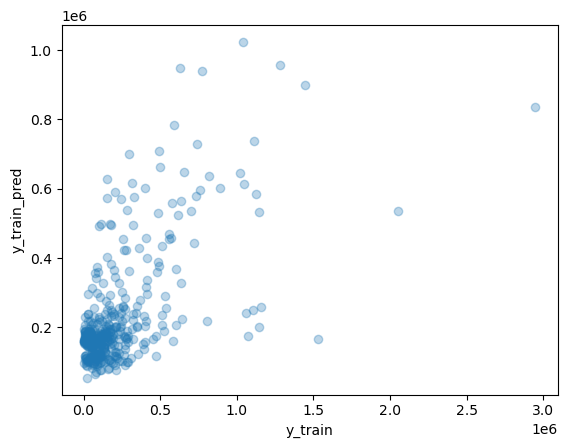

In [94]:
import matplotlib.pylab as plt

plt.scatter(y_test, model_lr.predict(X_test), alpha = 0.3)
plt.xlabel('y_train')
plt.ylabel('y_train_pred')

In [95]:
numeric_features = ['cost', 'weight', 'height', 'width', 'depth', 'year']
categorical_features = ['product_type']
target=['price']

X_train = train_raw[numeric_features + categorical_features ]
y_train = train_raw[target]

X_test = test_raw[numeric_features + categorical_features]
y_test = test_raw[target]
XGBRegressor

xgboost.sklearn.XGBRegressor

In [117]:
steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('numeric', DataTransformer(), numeric_features),  # Include 'cost' in the numeric features
            ('categorical', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_features)  # Produce dense matrix
        ],
        remainder='passthrough'
    )),
    ('xgbr', XGBRegressor(max_depth=3,learning_rate=0.05,n_estimators=100, min_child_weight = 3, reg_lambda=1))
]

model = Pipeline(steps)

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric', DataTransformer(),
                                                  ['cost', 'weight', 'height',
                                                   'width', 'depth', 'year']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['product_type'])])),
                ('xgbr',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsam...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None, min_child_weight=3,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, ...))])

In [118]:
y_train_pred = model.predict(X_train)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 9.54e+04
train MSE: 2.04e+10
train R2: 0.522
test MAE: 1.22e+05
test MSE: 4.64e+10
test R2: 0.461


Text(0, 0.5, 'y_train_pred')

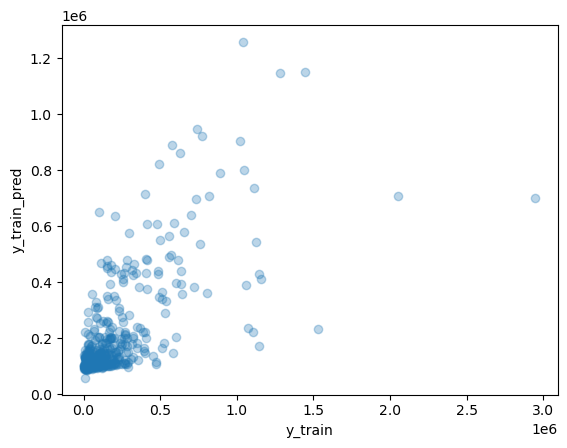

In [112]:
import matplotlib.pylab as plt

plt.scatter(y_test, model.predict(X_test), alpha = 0.3)
plt.xlabel('y_train')
plt.ylabel('y_train_pred')